# 读取数据

In [43]:
import os
import cv2
from tqdm import tqdm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *

In [44]:
import pickle
df1 = pickle.load(open('df5_results1.pkl', 'rb'))
df2 = pickle.load(open('df5_results2.pkl', 'rb'))
df3 = pickle.load(open('df5_results3.pkl', 'rb'))
df4 = pickle.load(open('df5_results4.pkl', 'rb'))
df5 = pickle.load(open('df5_results5.pkl', 'rb'))
df6 = pickle.load(open('df5_results6.pkl', 'rb'))
df7 = pickle.load(open('df5_results7.pkl', 'rb'))

In [45]:
import pandas as pd
df = pd.concat([df1, df2, df3, df4, df5, df6, df7], ignore_index=True)

In [46]:
df.head()

,images,activity,person
0,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36
1,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36
2,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36
3,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36
4,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36


In [47]:
df.shape

(3397, 3)

按类别名称进行编码：

In [48]:
from sklearn.preprocessing import LabelEncoder
activity_encoder = LabelEncoder()
df['activity_label'] = activity_encoder.fit_transform(df['activity'])

In [49]:
person_encoder = LabelEncoder()
df['person_label'] = person_encoder.fit_transform(df['person'])

In [50]:
df.head()

,images,activity,person,activity_label,person_label
0,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36,0,35
1,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36,0,35
2,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36,0,35
3,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36,0,35
4,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36,0,35


In [51]:
max(df['activity_label'])

5

In [52]:
max(df['person_label'])

71

# Activity classification

In [53]:
X_col = 'images'

In [54]:
y_col = 'activity_label'  # 后面直接改这个为person_label就好

进行数据集的划分：

In [55]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# 按照y进行分层采样
# 20%的数据作为测试集
for train_index, test_index in split.split(df, df[y_col]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [56]:
strat_train_set.shape

(2717, 5)

In [57]:
strat_test_set.shape

(680, 5)

接下来利用ImageDataGenerator来准备训练用的generator

In [58]:
# 图像归一化
# 并且划分20%的训练集数据作为验证集数据
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# 设置小批量的大小
batch_size = 32
# 统一图片的分辨率
target_size = (75, 125)

# 我们的dataframe中保存的路径足够
# 否则还需要指明directory来表示文件存放的路径
train_generator=datagen.flow_from_dataframe(dataframe=strat_train_set, 
                                            x_col=X_col,
                                            y_col=y_col,
                                            subset="training",
                                            seed=44,  # 随机数种子
                                            class_mode="raw",
                                            color_mode="grayscale",  # 按照灰度图处理
                                            target_size=target_size,  # 这里把图片变小
                                            batch_size=batch_size) # batch_size

# 划分验证集
valid_generator=datagen.flow_from_dataframe(dataframe=strat_train_set, 
                                            x_col=X_col,
                                            y_col=y_col,
                                            subset="validation",
                                            seed=44,  # 随机数种子
                                            class_mode="raw",
                                            color_mode="grayscale",  # 按照灰度图处理
                                            target_size=target_size,  # 这里把图片变小
                                            batch_size=batch_size) # batch_size

Found 2174 validated image filenames.
Found 543 validated image filenames.


分别查看训练集和验证集的数量：

In [59]:
train_generator.n

2174

In [60]:
train_generator.batch_size

32

In [61]:
valid_generator.n

543

In [62]:
valid_generator.batch_size

32

In [63]:
for X_batch, y_batch in train_generator:
    print(X_batch.shape)
    print(y_batch.shape)
    break

(32, 75, 125, 1)
(32,)


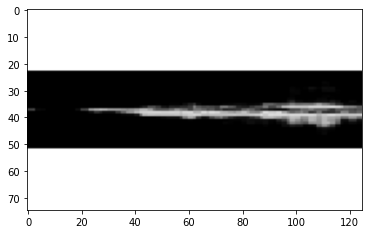

In [64]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(X_batch[0][:,:,0], cmap='gray')

In [65]:
y_batch[0]

0

构建test_generator

In [66]:
# 图像归一化
datagen=ImageDataGenerator(rescale=1./255)

# 我们的dataframe中保存的路径足够
# 否则还需要指明directory来表示文件存放的路径
test_generator=datagen.flow_from_dataframe(dataframe=strat_test_set, 
                                            x_col=X_col,
                                            y_col=y_col,
                                            class_mode="raw",
                                            color_mode="grayscale",  # 按照灰度图处理
                                            target_size=target_size,  # 这里把图片变小
                                            batch_size=batch_size) # batch_size

Found 680 validated image filenames.


In [67]:
test_generator.n

680

In [68]:
test_generator.batch_size

32

# 模型尝试

定义不同结构的模型并且进行比较：

In [69]:
nb_classes = max(df[y_col]) + 1

In [70]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, Flatten, Dropout

In [71]:
def make_model(nb_filters, img_rows, img_cols, nb_classes):
    """
    Make and return the CNN model
    :param nb_filters: Number of filters to use in layers 1,2 and 3,4 respectively
    :type nb_filters: str containing the number of filters for the first two layers followed by 
    the last two layers, for example: "16-32"
    :param img_rows: image height
    :type img_rows: int
    :param img_cols: image width
    :type img_cols: int
    :param nb_classes: Number of classes to be predicted
    :type nb_classes: int
    :return: CNN model
    :rtype: Keras sequential model
    """
    model = Sequential(name=nb_filters)
    nb_filters = nb_filters.split("-")
    size_1 = int(nb_filters[0])
    size_2 = int(nb_filters[1])

    model.add(Convolution2D(size_1, (3, 3), padding='same', input_shape=(img_rows, img_cols, 1), activation='relu'))
    model.add(Convolution2D(size_1, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(size_2, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(size_2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    return model

In [72]:
model = make_model('16-32', 75, 125, nb_classes)

In [73]:
model.summary()

Model: "16-32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 75, 125, 16)       160       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 73, 123, 16)       2320      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 61, 16)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 36, 61, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 36, 61, 32)        4640      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 34, 59, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 29, 32)        0     

In [74]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 30
batch_size = 32

history0 = model.fit(train_generator,
          steps_per_epoch=train_generator.n // train_generator.batch_size,
          validation_data=valid_generator,
          validation_steps=valid_generator.n // valid_generator.batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/30
67/67 [==============================] - 1s 20ms/step - loss: 1.2367 - accuracy: 0.5654 - val_loss: 0.7976 - val_accuracy: 0.6562
Epoch 2/30
67/67 [==============================] - 1s 18ms/step - loss: 0.7281 - accuracy: 0.7302 - val_loss: 0.6593 - val_accuracy: 0.7871
Epoch 3/30
67/67 [==============================] - 1s 18ms/step - loss: 0.5839 - accuracy: 0.7904 - val_loss: 0.4913 - val_accuracy: 0.8164
Epoch 4/30
67/67 [==============================] - 1s 18ms/step - loss: 0.4827 - accuracy: 0.8273 - val_loss: 0.4480 - val_accuracy: 0.8574
Epoch 5/30
67/67 [==============================] - 1s 18ms/step - loss: 0.4426 - accuracy: 0.8459 - val_loss: 0.4175 - val_accuracy: 0.8438
Epoch 6/30
67/67 [==============================] - 1s 18ms/step - loss: 0.3986 - accuracy: 0.8492 - val_loss: 0.3277 - val_accuracy: 0.8984
Epoch 7/30
67/67 [==============================] - 1s 19ms/step - loss: 0.3547 - accuracy: 0.8735 - val_loss: 0.3076 - val_accuracy: 0.8965
Epoch 8/30
67

In [75]:
history0.history

{'loss': [1.2366605997085571,
  0.7280990481376648,
  0.5839028358459473,
  0.48270806670188904,
  0.4425654411315918,
  0.3986310064792633,
  0.3547291159629822,
  0.32232266664505005,
  0.30441367626190186,
  0.2860891819000244,
  0.25907617807388306,
  0.2553691864013672,
  0.24190562963485718,
  0.22043320536613464,
  0.20755092799663544,
  0.20732448995113373,
  0.1844644993543625,
  0.2076805680990219,
  0.16516493260860443,
  0.1624961942434311,
  0.15592096745967865,
  0.15159793198108673,
  0.14100554585456848,
  0.1488524228334427,
  0.1272881180047989,
  0.11422882974147797,
  0.14716525375843048,
  0.12965065240859985,
  0.09807208180427551,
  0.10602185875177383],
 'accuracy': [0.5653594732284546,
  0.7301587462425232,
  0.7903828024864197,
  0.8272642493247986,
  0.8459383845329285,
  0.8492063283920288,
  0.8734827041625977,
  0.8828197717666626,
  0.8940242528915405,
  0.8916900157928467,
  0.913165271282196,
  0.9098972678184509,
  0.9084967374801636,
  0.9206349253654

训练集的准确率：

In [76]:
history0.history['accuracy'][-1]

0.9603174328804016

验证集的准确率：

In [77]:
history0.history['val_accuracy'][-1]

0.919921875

然后在测试集上评估：

In [78]:
loss, test_acc = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
test_acc

21/21 [==============================] - 0s 14ms/step - loss: 0.3123 - accuracy: 0.9271


0.9270833134651184

定义函数来评估不同结构的模型对应的结果：

In [79]:
def train_model(model):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    epochs = 100
    batch_size = 32

    history = model.fit(train_generator,
              steps_per_epoch=train_generator.n // train_generator.batch_size,
              validation_data=valid_generator,
              validation_steps=valid_generator.n // valid_generator.batch_size,
              epochs=epochs,
              verbose=1)
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    loss, test_acc = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
    return train_acc, val_acc, test_acc, history, model

评估不同卷积核大小对应的模型的表现：

In [80]:
model_types = ["2-4", "4-8", "8-16", "16-32", "32-64", "64-128"]

In [81]:
train_acc_list = []
val_acc_list = []
test_acc_list = []
history_list = []
model_list = []

In [82]:
for model_type in model_types:
    model = make_model(model_type, 75, 125, nb_classes)
    train_acc, val_acc, test_acc, history, model = train_model(model)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    history_list.append(history)
    model_list.append(model)

Epoch 1/100
67/67 [==============================] - 1s 21ms/step - loss: 1.3658 - accuracy: 0.5700 - val_loss: 1.1622 - val_accuracy: 0.5742
Epoch 2/100
67/67 [==============================] - 1s 19ms/step - loss: 0.9190 - accuracy: 0.6485 - val_loss: 0.8137 - val_accuracy: 0.7129
Epoch 3/100
67/67 [==============================] - 1s 18ms/step - loss: 0.7765 - accuracy: 0.7092 - val_loss: 0.6838 - val_accuracy: 0.7656
Epoch 4/100
67/67 [==============================] - 1s 18ms/step - loss: 0.7168 - accuracy: 0.7358 - val_loss: 0.6681 - val_accuracy: 0.7617
Epoch 5/100
67/67 [==============================] - 1s 18ms/step - loss: 0.6406 - accuracy: 0.7619 - val_loss: 0.5884 - val_accuracy: 0.8047
Epoch 6/100
67/67 [==============================] - 1s 18ms/step - loss: 0.6134 - accuracy: 0.7680 - val_loss: 0.5407 - val_accuracy: 0.8223
Epoch 7/100
67/67 [==============================] - 1s 18ms/step - loss: 0.5420 - accuracy: 0.7969 - val_loss: 0.5027 - val_accuracy: 0.8340
Epoch 

Epoch 15/100
67/67 [==============================] - 1s 18ms/step - loss: 0.3490 - accuracy: 0.8777 - val_loss: 0.3742 - val_accuracy: 0.8945
Epoch 16/100
67/67 [==============================] - 1s 18ms/step - loss: 0.3441 - accuracy: 0.8800 - val_loss: 0.3309 - val_accuracy: 0.9023
Epoch 17/100
67/67 [==============================] - 1s 18ms/step - loss: 0.3441 - accuracy: 0.8772 - val_loss: 0.3484 - val_accuracy: 0.8848
Epoch 18/100
67/67 [==============================] - 1s 18ms/step - loss: 0.3241 - accuracy: 0.8866 - val_loss: 0.3282 - val_accuracy: 0.8887
Epoch 19/100
67/67 [==============================] - 1s 18ms/step - loss: 0.3137 - accuracy: 0.8875 - val_loss: 0.3431 - val_accuracy: 0.8867
Epoch 20/100
67/67 [==============================] - 1s 18ms/step - loss: 0.3054 - accuracy: 0.8922 - val_loss: 0.3126 - val_accuracy: 0.9004
Epoch 21/100
67/67 [==============================] - 1s 18ms/step - loss: 0.2949 - accuracy: 0.8940 - val_loss: 0.2887 - val_accuracy: 0.9082

Epoch 29/100
67/67 [==============================] - 1s 18ms/step - loss: 0.1336 - accuracy: 0.9510 - val_loss: 0.2441 - val_accuracy: 0.9043
Epoch 30/100
67/67 [==============================] - 1s 18ms/step - loss: 0.1055 - accuracy: 0.9570 - val_loss: 0.3015 - val_accuracy: 0.8945
Epoch 31/100
67/67 [==============================] - 1s 18ms/step - loss: 0.1098 - accuracy: 0.9556 - val_loss: 0.2734 - val_accuracy: 0.9219
Epoch 32/100
67/67 [==============================] - 1s 18ms/step - loss: 0.1250 - accuracy: 0.9538 - val_loss: 0.2686 - val_accuracy: 0.9023
Epoch 33/100
67/67 [==============================] - 1s 18ms/step - loss: 0.1073 - accuracy: 0.9599 - val_loss: 0.2909 - val_accuracy: 0.9102
Epoch 34/100
67/67 [==============================] - 1s 18ms/step - loss: 0.0984 - accuracy: 0.9627 - val_loss: 0.2297 - val_accuracy: 0.9258
Epoch 35/100
67/67 [==============================] - 1s 18ms/step - loss: 0.1004 - accuracy: 0.9636 - val_loss: 0.2616 - val_accuracy: 0.9219

Epoch 43/100
67/67 [==============================] - 1s 18ms/step - loss: 0.0337 - accuracy: 0.9911 - val_loss: 0.4810 - val_accuracy: 0.9199
Epoch 44/100
67/67 [==============================] - 1s 18ms/step - loss: 0.0362 - accuracy: 0.9865 - val_loss: 0.4300 - val_accuracy: 0.9141
Epoch 45/100
67/67 [==============================] - 1s 18ms/step - loss: 0.0728 - accuracy: 0.9748 - val_loss: 0.3649 - val_accuracy: 0.9160
Epoch 46/100
67/67 [==============================] - 1s 20ms/step - loss: 0.0317 - accuracy: 0.9911 - val_loss: 0.4291 - val_accuracy: 0.9082
Epoch 47/100
67/67 [==============================] - 1s 18ms/step - loss: 0.0210 - accuracy: 0.9935 - val_loss: 0.4399 - val_accuracy: 0.9160
Epoch 48/100
67/67 [==============================] - 1s 18ms/step - loss: 0.0293 - accuracy: 0.9893 - val_loss: 0.4177 - val_accuracy: 0.9121
Epoch 49/100
67/67 [==============================] - 1s 18ms/step - loss: 0.0296 - accuracy: 0.9869 - val_loss: 0.5143 - val_accuracy: 0.9004

Epoch 57/100
67/67 [==============================] - 1s 19ms/step - loss: 0.0450 - accuracy: 0.9846 - val_loss: 0.3419 - val_accuracy: 0.9355
Epoch 58/100
67/67 [==============================] - 1s 19ms/step - loss: 0.0427 - accuracy: 0.9846 - val_loss: 0.3666 - val_accuracy: 0.9160
Epoch 59/100
67/67 [==============================] - 1s 18ms/step - loss: 0.0436 - accuracy: 0.9823 - val_loss: 0.3192 - val_accuracy: 0.9336
Epoch 60/100
67/67 [==============================] - 1s 18ms/step - loss: 0.0242 - accuracy: 0.9916 - val_loss: 0.3728 - val_accuracy: 0.9316
Epoch 61/100
67/67 [==============================] - 1s 18ms/step - loss: 0.0291 - accuracy: 0.9888 - val_loss: 0.3898 - val_accuracy: 0.9219
Epoch 62/100
67/67 [==============================] - 1s 18ms/step - loss: 0.0623 - accuracy: 0.9813 - val_loss: 0.2969 - val_accuracy: 0.9336
Epoch 63/100
67/67 [==============================] - 1s 18ms/step - loss: 0.0290 - accuracy: 0.9893 - val_loss: 0.3253 - val_accuracy: 0.9219

Epoch 14/100
67/67 [==============================] - 2s 34ms/step - loss: 0.1618 - accuracy: 0.9370 - val_loss: 0.2484 - val_accuracy: 0.9121
Epoch 15/100
67/67 [==============================] - 2s 34ms/step - loss: 0.1552 - accuracy: 0.9402 - val_loss: 0.2747 - val_accuracy: 0.9160
Epoch 16/100
67/67 [==============================] - 2s 34ms/step - loss: 0.1497 - accuracy: 0.9412 - val_loss: 0.2406 - val_accuracy: 0.9277
Epoch 17/100
67/67 [==============================] - 2s 34ms/step - loss: 0.1222 - accuracy: 0.9510 - val_loss: 0.2424 - val_accuracy: 0.9082
Epoch 18/100
67/67 [==============================] - 2s 34ms/step - loss: 0.1461 - accuracy: 0.9514 - val_loss: 0.2371 - val_accuracy: 0.9062
Epoch 19/100
67/67 [==============================] - 2s 34ms/step - loss: 0.1044 - accuracy: 0.9594 - val_loss: 0.2594 - val_accuracy: 0.9160
Epoch 20/100
67/67 [==============================] - 2s 34ms/step - loss: 0.1082 - accuracy: 0.9608 - val_loss: 0.2548 - val_accuracy: 0.9297

In [83]:
results = pd.DataFrame({'model_types': model_types, 'train_acc': train_acc_list, 'val_acc': val_acc_list, 'test_acc': test_acc_list})

In [84]:
results

,model_types,train_acc,val_acc,test_acc
0,2-4,0.972923,0.884766,0.882440
1,4-8,0.963119,0.902344,0.916667
2,8-16,0.992063,0.933594,0.936012
3,16-32,0.992997,0.917969,0.921131
4,32-64,0.992063,0.927734,0.933036
5,64-128,0.995798,0.925781,0.934524


找到最好的模型，画出训练过程中的准确率和loss的变化曲线，以及最终测试集上的confusion matrix

In [85]:
final_history = history_list[2]
final_model = model_list[2]

In [89]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['font.size'] = 20

In [90]:
def plot_training(history, save_fn):
    import pandas as pd
    import matplotlib.pyplot as plt
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=[12, 9])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
             label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
             label = 'Validation Accuracy')
    plt.legend()
    
    plt.savefig(save_fn, dpi=400, bbox_inches='tight')

In [91]:
def plot_training_loss(history, save_fn):
    import pandas as pd
    import matplotlib.pyplot as plt
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=[12, 9])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
             label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],
             label = 'Validation Loss')
    plt.legend()
    
    plt.savefig(save_fn, dpi=400, bbox_inches='tight')

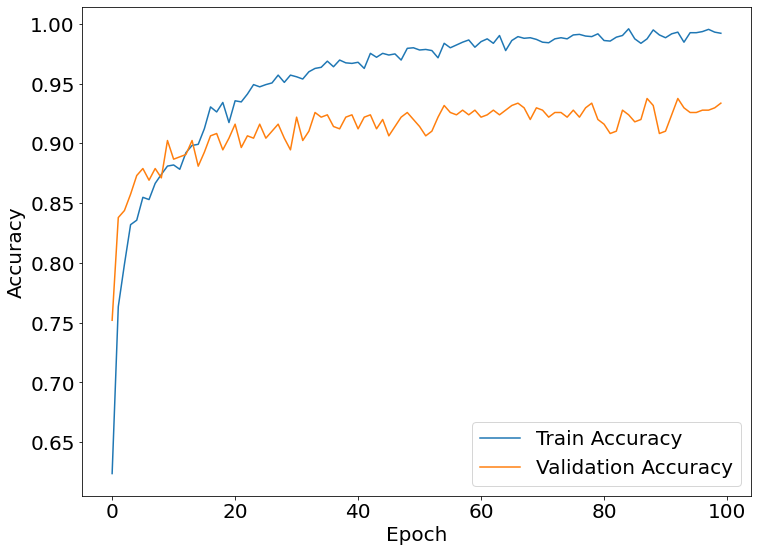

In [92]:
plot_training(final_history, 'activity_accuracy.png')

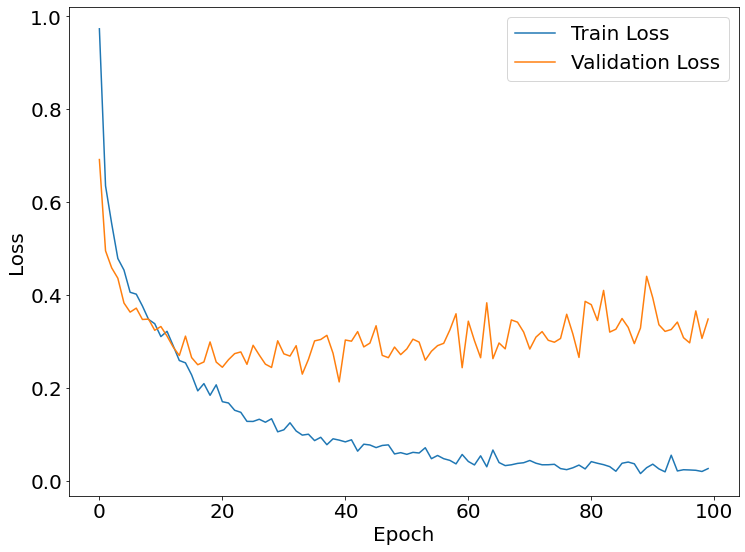

In [93]:
plot_training_loss(final_history, 'activity_loss.png')

利用预测所有的测试样本：

In [94]:
strat_test_set.shape

(680, 5)

In [95]:
# 图像归一化
datagen=ImageDataGenerator(rescale=1./255)

test_generator=datagen.flow_from_dataframe(dataframe=strat_test_set, 
                                            x_col=X_col,
                                            y_col=y_col,
                                            class_mode="raw",
                                            color_mode="grayscale",  # 按照灰度图处理
                                            target_size=target_size,  # 把图片变小
                                            batch_size=strat_test_set.shape[0]) # 一次读取所有测试图片

Found 680 validated image filenames.


In [99]:
for X_batch, y_batch in test_generator:
    print(X_batch.shape)
    y_true = y_batch
    y_pred = final_model.predict(X_batch)
    break

(680, 75, 125, 1)


In [100]:
y_true.shape

(680,)

In [101]:
y_pred.shape

(680, 6)

In [106]:
import numpy as np
y_pred_labels = np.floor(np.argmax(y_pred, axis=1)).astype(int)

In [107]:
y_pred_labels[0]

3

In [105]:
y_pred[0]

array([5.19752545e-16, 1.74448118e-07, 7.29921124e-10, 9.99879241e-01,
       1.20587974e-04, 1.28314037e-12], dtype=float32)

把标签映射为相应的动作：

In [110]:
activity_encoder.inverse_transform([0, 1, 2, 3, 4, 5])

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [111]:
activity_list = ['walking', 'sitting down', 'stand up', 'pick up an object', 'drink water', 'fall']

In [112]:
y_true_names = [activity_list[i] for i in y_true]
y_pred_names = [activity_list[i] for i in y_pred_labels]

In [113]:
y_true_names[0]

'pick up an object'

In [114]:
y_pred_names[0]

'pick up an object'

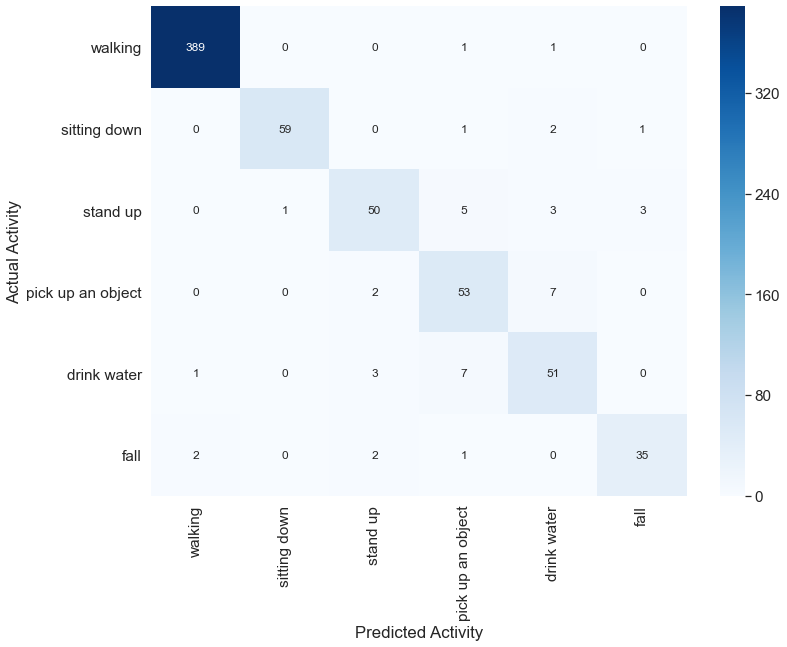

In [115]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

data = confusion_matrix(y_true_names, y_pred_names)
df_cm = pd.DataFrame(data, columns=np.unique(y_true_names), index = np.unique(y_true_names))
df_cm = df_cm.reindex(columns=activity_list, index=activity_list)
df_cm.index.name = 'Actual Activity'
df_cm.columns.name = 'Predicted Activity'
plt.figure(figsize = (12, 9))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 12})  # font size
plt.savefig('activities-confusion-matrix.png', dpi=400, bbox_inches='tight')